## Setup

In [1]:
%matplotlib inline

In [2]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [3]:
from aif360.datasets import StandardDataset
StandardDataset??

In [4]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGRMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 

## Arguments & Initializations

In [5]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade ")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")

_StoreAction(option_strings=['-o', '--os'], dest='os', nargs=None, const=None, default=2, type=None, choices=None, required=False, help='oversample mode: 1: privi unfav 2: unpriv fav', metavar=None)

In [6]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [7]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2}

In [8]:
DATASET = "bank"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])

In [9]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 3 

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

egr_metrics = defaultdict(list) 
egr_mia_metrics = defaultdict(list) 


pr_orig_metrics = defaultdict(list) 
cpp_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [10]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

# training data split ratio
p = 0.5

In [11]:
dataset_orig.features.shape

(30488, 57)

In [12]:
privileged_groups

[{'age': 1}]

In [13]:
# split dataset into train, validation, and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
dataset_orig_val = dataset_orig_test
print(dataset_orig_train.features)

[[  1. 204.   1. ...   0.   1.   0.]
 [  1. 264.   1. ...   0.   1.   0.]
 [  1. 259.   2. ...   0.   1.   0.]
 ...
 [  1. 561.   2. ...   0.   1.   0.]
 [  1. 147.   3. ...   0.   1.   0.]
 [  1. 258.   1. ...   0.   1.   0.]]


In [14]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig_train.favorable_label
uf_label = dataset_orig_train.unfavorable_label
feature_names = dataset_orig_train.feature_names

# introduce label or selection biases, assuming the original data is fair
if BIAS_TYPE == 'label':
    dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
elif BIAS_TYPE == 'selection':
    dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
else:
    print('no bias type specified')

no bias type specified


In [15]:
dataset_orig_train

               instance weights            features                           \
                                protected attribute                            
                                                age duration campaign  pdays   
instance names                                                                 
30261                       1.0                 1.0    204.0      1.0  999.0   
38822                       1.0                 1.0    264.0      1.0  999.0   
35475                       1.0                 1.0    259.0      2.0  999.0   
22859                       1.0                 1.0    366.0      3.0  999.0   
28814                       1.0                 1.0   1007.0      3.0  999.0   
...                         ...                 ...      ...      ...    ...   
18510                       1.0                 1.0    126.0      1.0  999.0   
15734                       1.0                 1.0    115.0      1.0  999.0   
40169                       1.0         

In [16]:
dataset_orig_train?

## Run Mitigating Algorithms

In [17]:
# run mitigating algorithms
for i in range(N):
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print("#### Train dataset's features are as below:")
    print(dataset_orig_train.features)

    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig_train.favorable_label
    uf_label = dataset_orig_train.unfavorable_label
    feature_names = dataset_orig_train.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, OS_MODE, SCALER)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # egr mitigator, in-processing
    egr_metrics, egr_mia_metrics = test_cases.run_egr(dataset_orig_train, dataset_orig_val, dataset_orig_test, egr_metrics, egr_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups,THRESH_ARR, DISPLAY, SCALER)
    # egr gave error so I replaced it with reweigh
#     egr_metrics, egr_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, egr_metrics, egr_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # cpp mitigator
    cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    # ro mitigator
    # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    if (BASELINE == 'lr'):
        pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

#### Train dataset's features are as below:
[[  1. 177.   1. ...   0.   1.   0.]
 [  1. 131.   3. ...   1.   0.   0.]
 [  1. 139.   2. ...   0.   1.   0.]
 ...
 [  1. 251.   2. ...   0.   1.   0.]
 [  1. 236.   3. ...   0.   1.   0.]
 [  1. 245.   4. ...   0.   1.   0.]]
no bias type specified
#### Training Dataset shape
(15244, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected groups
[{'age': 1}] [{'age': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job=admin.', 'job=blue-collar', 'job=entrepreneur', 'job=housemaid', 'job=management', 'job=retired', 'job=self-employed', 'job=services', 'job=student', 'job=technician', 'job=unemployed', 'marital=divorced', 'marital=married', 'marital=single', 'educatio

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 347
Number of test samples (ntest): 318
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 94
Number of test samples (ntest): 105
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12959
Number of test samples (ntest): 13005
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1844
Number of test samples (ntest): 1816
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: -0.5205344378929516
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13306, Test = 13323
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.03
  Positive predictiv

Number of training samples (ntrain): 12959
Number of test samples (ntest): 13005
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1844
Number of test samples (ntest): 1816
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.04
  Positive predictive value: 0.60
  Optimal thershold: -0.7731898882334817
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13306, Test = 13323
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.03
  Attacker advantage: 0.02
  Positive predictive value: 0.59
  Optimal thershold: -0.9808292530117262
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1938, Test = 1921
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.44


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 347
Number of test samples (ntest): 318
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 94
Number of test samples (ntest): 105
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12959
Number of test samples (ntest): 13005
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1844
Number of test samples (ntest): 1816
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.50
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.10
  Positive predictive value: 0.53
  Optimal thershold: -0.9808292530117262
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13306, Test = 13323
  AUC: 0.47
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.09
  Positive predictiv

Number of training samples (ntrain): 12959
Number of test samples (ntest): 13005
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1844
Number of test samples (ntest): 1816
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: -0.6076581164450604
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13306, Test = 13323
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.6076581164450604
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1938, Test = 1921
  AUC: 0.63
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.30


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Accuracy for threshold: 0.01  is: 0.8951062713198635
Balanced accuracy is:  0.8076762940003125
Accuracy for threshold: 0.02  is: 0.8951062713198635
Balanced accuracy is:  0.8076762940003125
Accuracy for threshold: 0.03  is: 0.8951062713198635
Balanced accuracy is:  0.8076762940003125
Accuracy for threshold: 0.04  is: 0.8951062713198635
Balanced accuracy is:  0.8076762940003125
Accuracy for threshold: 0.05  is: 0.8951062713198635
Balanced accuracy is:  0.8076762940003125
Accuracy for threshold: 0.060000000000000005  is: 0.8951062713198635
Balanced accuracy is:  0.8076762940003125
Accuracy for threshold: 0.06999999999999999  is: 0.8951062713198635
Balanced accuracy is:  0.8076762940003125
Accuracy for threshold: 0.08  is: 0.8951062713198635
Balanced accuracy is:  0.8076762940003125
Accuracy for threshold: 0.09  is: 0.8951062713198635
Balanced accuracy is:  0.8076762940003125
Accuracy for threshold: 0.09999999999999999  is: 0.8951062713198635
Balanced accuracy is:  0.8076762940003125
Accu

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid

True positive rate is:  0.6907860489328475
True negative rate is:  0.9245665390677775
Balanced accuracy is:  0.8076762940003125
Test Accuracy is:  0.8951062713198635
Best balanced accuracy: 0.8077
Corresponding 1-min(DI, 1/DI) value: 0.4645
Corresponding average odds difference value: 0.0944
Corresponding statistical parity difference value: 0.1709
Corresponding equal opportunity difference value: 0.0954
Corresponding Theil index value: 0.0624
Corresponding false positive_rate for privileged: 0.0732
Corresponding false negative_rate for privileged: 0.3144
Corresponding false positive_rate for unpribileged: 0.1667
Corresponding false negative_rate for unprivileged: 0.2190
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 347
Number of test samples (ntest): 318
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 94
Number of test samples (ntest): 105
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12959
Number of test samp

Accuracy for threshold: 0.28  is: 0.887037522959853
Balanced accuracy is:  0.8015989569381721
Accuracy for threshold: 0.29000000000000004  is: 0.8879559170821306
Balanced accuracy is:  0.8001027939066275
Accuracy for threshold: 0.3  is: 0.8888743112044083
Balanced accuracy is:  0.798382068869245
Accuracy for threshold: 0.31  is: 0.8899239044870113
Balanced accuracy is:  0.7962872048231864
Accuracy for threshold: 0.32  is: 0.8904487011283128
Balanced accuracy is:  0.791197656695076
Accuracy for threshold: 0.33  is: 0.8904487011283128
Balanced accuracy is:  0.791197656695076
Accuracy for threshold: 0.34  is: 0.891432694830753
Balanced accuracy is:  0.7863705560774638
Accuracy for threshold: 0.35000000000000003  is: 0.891432694830753
Balanced accuracy is:  0.7863705560774638
Accuracy for threshold: 0.36000000000000004  is: 0.8908422986092889
Balanced accuracy is:  0.782664693476399
Accuracy for threshold: 0.37  is: 0.8926790868538441
Balanced accuracy is:  0.7747320032848777
Accuracy for 

Accuracy for threshold: 0.34  is: 0.8960246654421412
Balanced accuracy is:  0.7649668965577954
Accuracy for threshold: 0.35000000000000003  is: 0.8960246654421412
Balanced accuracy is:  0.7649668965577954
Accuracy for threshold: 0.36000000000000004  is: 0.8960246654421412
Balanced accuracy is:  0.7649668965577954
Accuracy for threshold: 0.37  is: 0.8960246654421412
Balanced accuracy is:  0.7649668965577954
Accuracy for threshold: 0.38  is: 0.8960246654421412
Balanced accuracy is:  0.7649668965577954
Accuracy for threshold: 0.39  is: 0.8960246654421412
Balanced accuracy is:  0.7649668965577954
Accuracy for threshold: 0.4  is: 0.8959590658619785
Balanced accuracy is:  0.76448028004462
Accuracy for threshold: 0.41000000000000003  is: 0.8959590658619785
Balanced accuracy is:  0.76448028004462
Accuracy for threshold: 0.42000000000000004  is: 0.8979926528470218
Balanced accuracy is:  0.7571091913692733
Accuracy for threshold: 0.43  is: 0.8979926528470218
Balanced accuracy is:  0.757109191369

Accuracy for threshold: 0.25  is: 0.8783127787982157
Balanced accuracy is:  0.8206405888633594
Accuracy for threshold: 0.26  is: 0.8794279716609814
Balanced accuracy is:  0.8201551513596652
Accuracy for threshold: 0.27  is: 0.8794279716609814
Balanced accuracy is:  0.8201551513596652
Accuracy for threshold: 0.28  is: 0.8804775649435843
Balanced accuracy is:  0.8205304693778226
Accuracy for threshold: 0.29000000000000004  is: 0.8860535292574128
Balanced accuracy is:  0.8053032475265953
Accuracy for threshold: 0.3  is: 0.8860535292574128
Balanced accuracy is:  0.8053032475265953
Accuracy for threshold: 0.31  is: 0.8890055103647336
Balanced accuracy is:  0.7944149377671635
Accuracy for threshold: 0.32  is: 0.8890055103647336
Balanced accuracy is:  0.7944149377671635
Accuracy for threshold: 0.33  is: 0.8890055103647336
Balanced accuracy is:  0.7944149377671635
Accuracy for threshold: 0.34  is: 0.8892679086853844
Balanced accuracy is:  0.7889508576272167
Accuracy for threshold: 0.3500000000

Accuracy for threshold: 0.37  is: 0.8897271057465233
Balanced accuracy is:  0.7669816665597697
Accuracy for threshold: 0.38  is: 0.8897271057465233
Balanced accuracy is:  0.7669816665597697
Accuracy for threshold: 0.39  is: 0.8902519023878247
Balanced accuracy is:  0.756278068285714
Accuracy for threshold: 0.4  is: 0.8903175019679874
Balanced accuracy is:  0.7524980066879705
Accuracy for threshold: 0.41000000000000003  is: 0.8903175019679874
Balanced accuracy is:  0.7524980066879705
Accuracy for threshold: 0.42000000000000004  is: 0.8903175019679874
Balanced accuracy is:  0.7524980066879705
Accuracy for threshold: 0.43  is: 0.8916950931514038
Balanced accuracy is:  0.7350958267466003
Accuracy for threshold: 0.44  is: 0.8926134872736814
Balanced accuracy is:  0.7347224737442448
Accuracy for threshold: 0.45  is: 0.8926134872736814
Balanced accuracy is:  0.7347224737442448
Accuracy for threshold: 0.46  is: 0.8926134872736814
Balanced accuracy is:  0.7347224737442448
Accuracy for threshold

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Accuracy for threshold: 0.01  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.02  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.03  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.04  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.05  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.060000000000000005  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.06999999999999999  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.08  is: 0.8949094725793755
Balanced accuracy is:  0.7151504447538165
Accuracy for threshold: 0.09  is: 0.8949094725793755
Balanced accuracy is:  0.7151504447538165
Accuracy for threshold: 0.09999999999999999  is: 0.8949094725793755
Balanced accuracy is:  0.7151504447538165
Accu

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid

True positive rate is:  0.5833333333333334
True negative rate is:  0.9385122975404919
Balanced accuracy is:  0.7609228154369126
Test Accuracy is:  0.8940566780372605
Best balanced accuracy: 0.7609
Corresponding 1-min(DI, 1/DI) value: 0.6273
Corresponding average odds difference value: -0.0370
Corresponding statistical parity difference value: 0.0740
Corresponding equal opportunity difference value: -0.1335
Corresponding Theil index value: 0.0728
Corresponding false positive_rate for privileged: 0.0600
Corresponding false negative_rate for privileged: 0.4093
Corresponding false positive_rate for unpribileged: 0.1195
Corresponding false negative_rate for unprivileged: 0.5429
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 322
Number of test samples (ntest): 343
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 94
Number of test samples (ntest): 105
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12971
Number of test sa

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


Best balanced accuracy: 0.5119
Corresponding 1-min(DI, 1/DI) value: 0.0000
Corresponding average odds difference value: 0.2983
Corresponding statistical parity difference value: 0.1987
Corresponding equal opportunity difference value: 0.4857
Corresponding Theil index value: 0.1310
Corresponding false positive_rate for privileged: 0.0000
Corresponding false negative_rate for privileged: 1.0000
Corresponding false positive_rate for unpribileged: 0.1108
Corresponding false negative_rate for unprivileged: 0.5143
#### Train dataset's features are as below:
[[  1. 118.   3. ...   0.   1.   0.]
 [  1.  78.   1. ...   0.   1.   0.]
 [  0.  93.   2. ...   0.   1.   0.]
 ...
 [  1.  89.   1. ...   0.   1.   0.]
 [  1. 201.   5. ...   0.   1.   0.]
 [  0. 109.   2. ...   0.   1.   0.]]
no bias type specified
#### Training Dataset shape
(15244, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected groups
[{'age': 1}] [{'

Number of training samples (ntrain): 12971
Number of test samples (ntest): 12993
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1857
Number of test samples (ntest): 1803
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.04
  Positive predictive value: 0.59
  Optimal thershold: -0.8020727623822678
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13293, Test = 13336
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.03
  Positive predictive value: 0.57
  Optimal thershold: -0.5465437063680699
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1951, Test = 1908
  AUC: 0.63
  Privacy Risk: 0.59
  Accuracy: 0.60
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.41


Number of training samples (ntrain): 12971
Number of test samples (ntest): 12993
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1857
Number of test samples (ntest): 1803
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.04
  Positive predictive value: 0.60
  Optimal thershold: -0.8815477834302822
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13293, Test = 13336
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.02
  Positive predictive value: 0.57
  Optimal thershold: -0.8472978603872036
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1951, Test = 1908
  AUC: 0.62
  Privacy Risk: 0.58
  Accuracy: 0.59
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.52


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 322
Number of test samples (ntest): 343
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 94
Number of test samples (ntest): 105
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12971
Number of test samples (ntest): 12993
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1857
Number of test samples (ntest): 1803
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.04
  Positive predictive value: 0.57
  Optimal thershold: -0.49441259412466054
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13293, Test = 13336
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.03
  Positive predicti

Number of training samples (ntrain): 12971
Number of test samples (ntest): 12993
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1857
Number of test samples (ntest): 1803
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.05
  Positive predictive value: 0.59
  Optimal thershold: -0.6807952730517138
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13293, Test = 13336
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.03
  Positive predictive value: 0.57
  Optimal thershold: -0.6506731268699822
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1951, Test = 1908
  AUC: 0.63
  Privacy Risk: 0.60
  Accuracy: 0.61
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.43


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Accuracy for threshold: 0.01  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.02  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.03  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.04  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.05  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.060000000000000005  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.06999999999999999  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.08  is: 0.8949094725793755
Balanced accuracy is:  0.7151504447538165
Accuracy for threshold: 0.09  is: 0.8949094725793755
Balanced accuracy is:  0.7151504447538165
Accuracy for threshold: 0.09999999999999999  is: 0.8949094725793755
Balanced accuracy is:  0.7151504447538165
Accu

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid

True positive rate is:  0.5833333333333334
True negative rate is:  0.9385122975404919
Balanced accuracy is:  0.7609228154369126
Test Accuracy is:  0.8940566780372605
Best balanced accuracy: 0.7609
Corresponding 1-min(DI, 1/DI) value: 0.6273
Corresponding average odds difference value: -0.0370
Corresponding statistical parity difference value: 0.0740
Corresponding equal opportunity difference value: -0.1335
Corresponding Theil index value: 0.0728
Corresponding false positive_rate for privileged: 0.0600
Corresponding false negative_rate for privileged: 0.4093
Corresponding false positive_rate for unpribileged: 0.1195
Corresponding false negative_rate for unprivileged: 0.5429
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 322
Number of test samples (ntest): 343
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 94
Number of test samples (ntest): 105
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12971
Number of test sa

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


In [18]:
X = dataset_orig.features

## Display Output

In [19]:
if isinstance(X, pd.DataFrame):
    A = X[[0]]  # For DataFrame, use column names
    print("For dataframe, A: ", A)
else:
    A = X[:, [0]]  # For NumPy array, use column indices
    print(len(A))
    print("For non-dataframe, A: ", A)

30488
For non-dataframe, A:  [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [20]:
priv_metric_orig_copy = priv_metric_orig

In [21]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 44459.0, 'total_unpriv': 1273.0})

In [22]:
priv_metric_orig

defaultdict(float, {'total_priv': 44459.0, 'total_unpriv': 1273.0})

In [23]:
priv_metric_orig = priv_metric_orig_copy

1)

bank
15244
2)

                total_priv  total_unpriv
num_instance                            
orig          14819.666667    424.333333
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.127701       0.872299    0.125014      0.874986      0.221692   
transf      0.125014       0.874986    0.125014      0.874986      0.125014   

         unpriv_unfavor  
dataset                  
orig           0.778308  
transf         0.874986  
4)

                            bal_acc  avg_odds_diff  disp_imp  stat_par_diff  \
Classifier Bias Mitigator                                                     
dt_orig                    0.834690       0.041248  0.419219       0.155741   
dt_syn                     0.732737       0.019972  0.488325       0.106987   
dt_dir                     0.825596       0.077444  0.489482       0.229257   
dt_rew                     0.82951

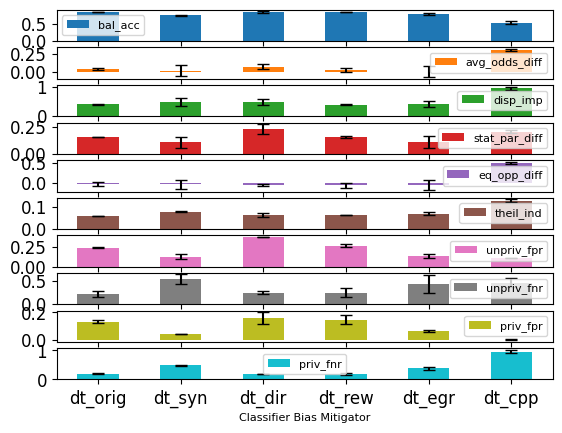

In [24]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
egr_error_metrics = {k: [statistics.stdev(v)] for (k,v) in egr_metrics.items()}
pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
egr_metrics_mean = {k:[sum(v)/N] for (k,v) in egr_metrics.items()}
pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

if BASELINE == 'lr':
    plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print("5)")
    print(stat)
else:
    plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print(stat)

plt.show()

# Visualization

### Fairness

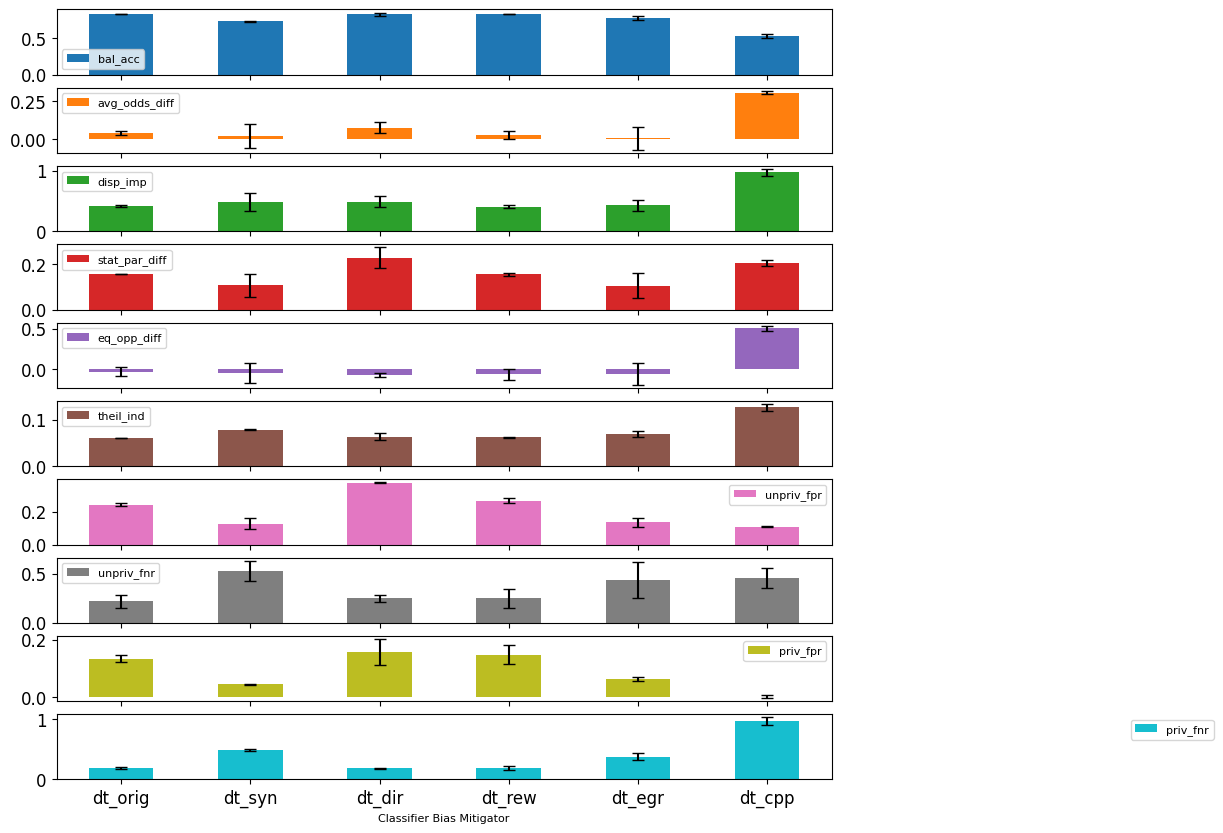

In [25]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        egr_metrics_mean,
        pr_orig_metrics_mean,
        cpp_metrics_mean,
        ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        egr_error_metrics,
        pr_orig_error_metrics,
        cpp_error_metrics,
        ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn']+ [model_type+'_dir']+ [model_type+'_rew']+ [model_type+'_egr'] + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

In [26]:
df

,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind,unpriv_fpr,unpriv_fnr,priv_fpr,priv_fnr
Classifier Bias Mitigator,,,,,,,,,,
dt_orig,0.834690,0.041248,0.419219,0.155741,-0.026459,0.060307,0.242777,0.219048,0.133821,0.192588
dt_syn,0.732737,0.019972,0.488325,0.106987,-0.042242,0.078479,0.127580,0.526984,0.045395,0.484743
dt_dir,0.825596,0.077444,0.489482,0.229257,-0.065780,0.063388,0.378459,0.247619,0.157790,0.181839
dt_rew,0.829513,0.029461,0.405053,0.155054,-0.061248,0.062107,0.268371,0.247619,0.148202,0.186371
dt_egr,0.776507,0.006820,0.426948,0.106326,-0.057233,0.069337,0.135245,0.434921,0.064371,0.377688
dt_cpp,0.530102,0.305225,0.968504,0.205937,0.504311,0.126836,0.109498,0.457143,0.003358,0.961454


## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [27]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [28]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.521932,0.512957,0.591107,0.539607,0.622746,0.512344,0.590285
syn,0.519079,0.511181,0.579634,0.564451,0.655910,0.509972,0.576506
dir,0.531072,0.523524,0.591366,0.590668,0.680902,0.522271,0.587498
rew,0.523321,0.513579,0.599852,0.538455,0.616869,0.513354,0.600426
egr,0.523900,0.514833,0.591611,0.548219,0.629787,0.513984,0.592969


In [29]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [30]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [31]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.539607,0.622746,0.512344,0.590285
syn,0.564451,0.655910,0.509972,0.576506
dir,0.590668,0.680902,0.522271,0.587498
rew,0.538455,0.616869,0.513354,0.600426
egr,0.548219,0.629787,0.513984,0.592969


<Axes: xlabel='Classifier MIA Attacks'>

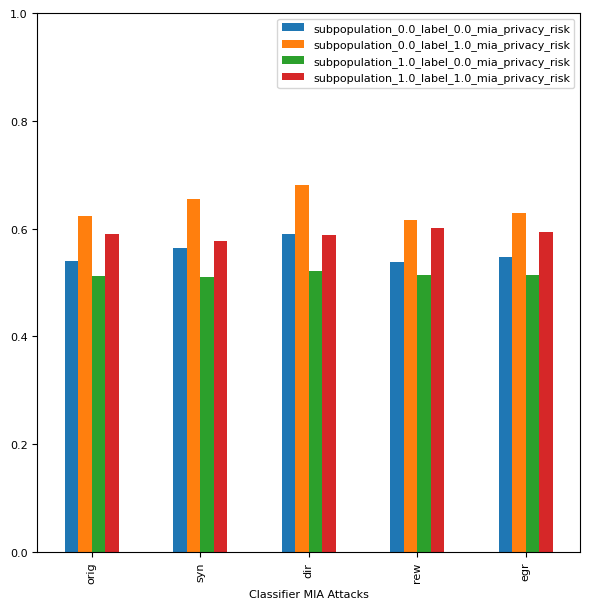

In [32]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [33]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew       egr
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.539607  0.564451  0.590668  0.538455  0.548219
subpopulation_0.0_label_1.0_mia_privacy_risk  0.622746  0.65591   0.680902  0.616869  0.629787
subpopulation_1.0_label_0.0_mia_privacy_risk  0.512344  0.509972  0.522271  0.513354  0.513984
subpopulation_1.0_label_1.0_mia_privacy_risk  0.590285  0.576506  0.587498  0.600426  0.592969


### Visualizing using novel technique

In [34]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [35]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])

In [36]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.521648
1,orig,entire_dataset_mia_privacy_risk,0.522074
2,orig,entire_dataset_mia_privacy_risk,0.522074
3,orig,entire_dataset_label_0.0_mia_privacy_risk,0.513049
4,orig,entire_dataset_label_0.0_mia_privacy_risk,0.512911
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.514019
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.514019
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.590448
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.594230


In [37]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.521648
1,orig,entire_dataset_mia_privacy_risk,0.522074
2,orig,entire_dataset_mia_privacy_risk,0.522074
9,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.526603
10,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.546109
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.514019
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.514019
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.590448
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.594230


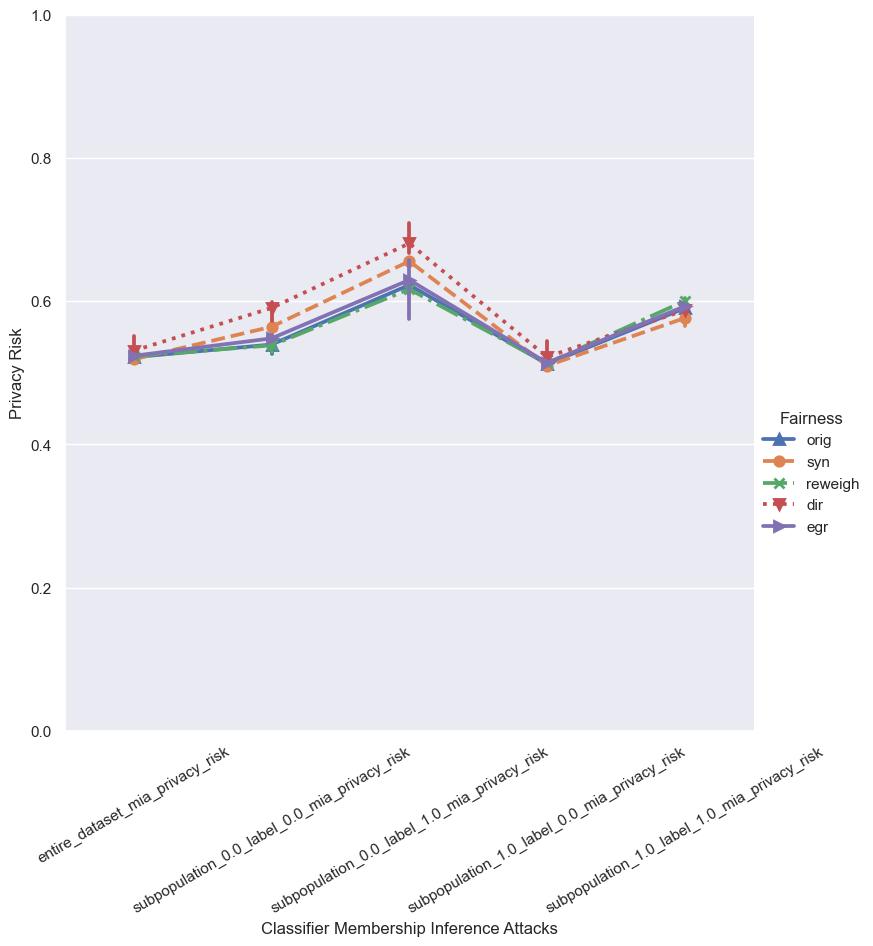

In [38]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [39]:
from sklearn.metrics import RocCurveDisplay, auc

In [40]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

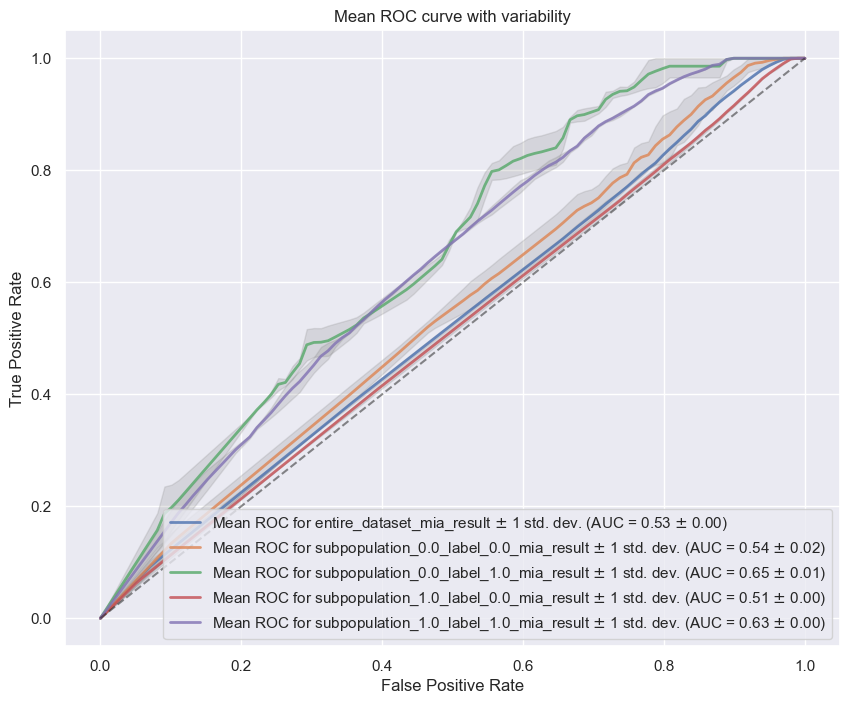

In [41]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result", "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

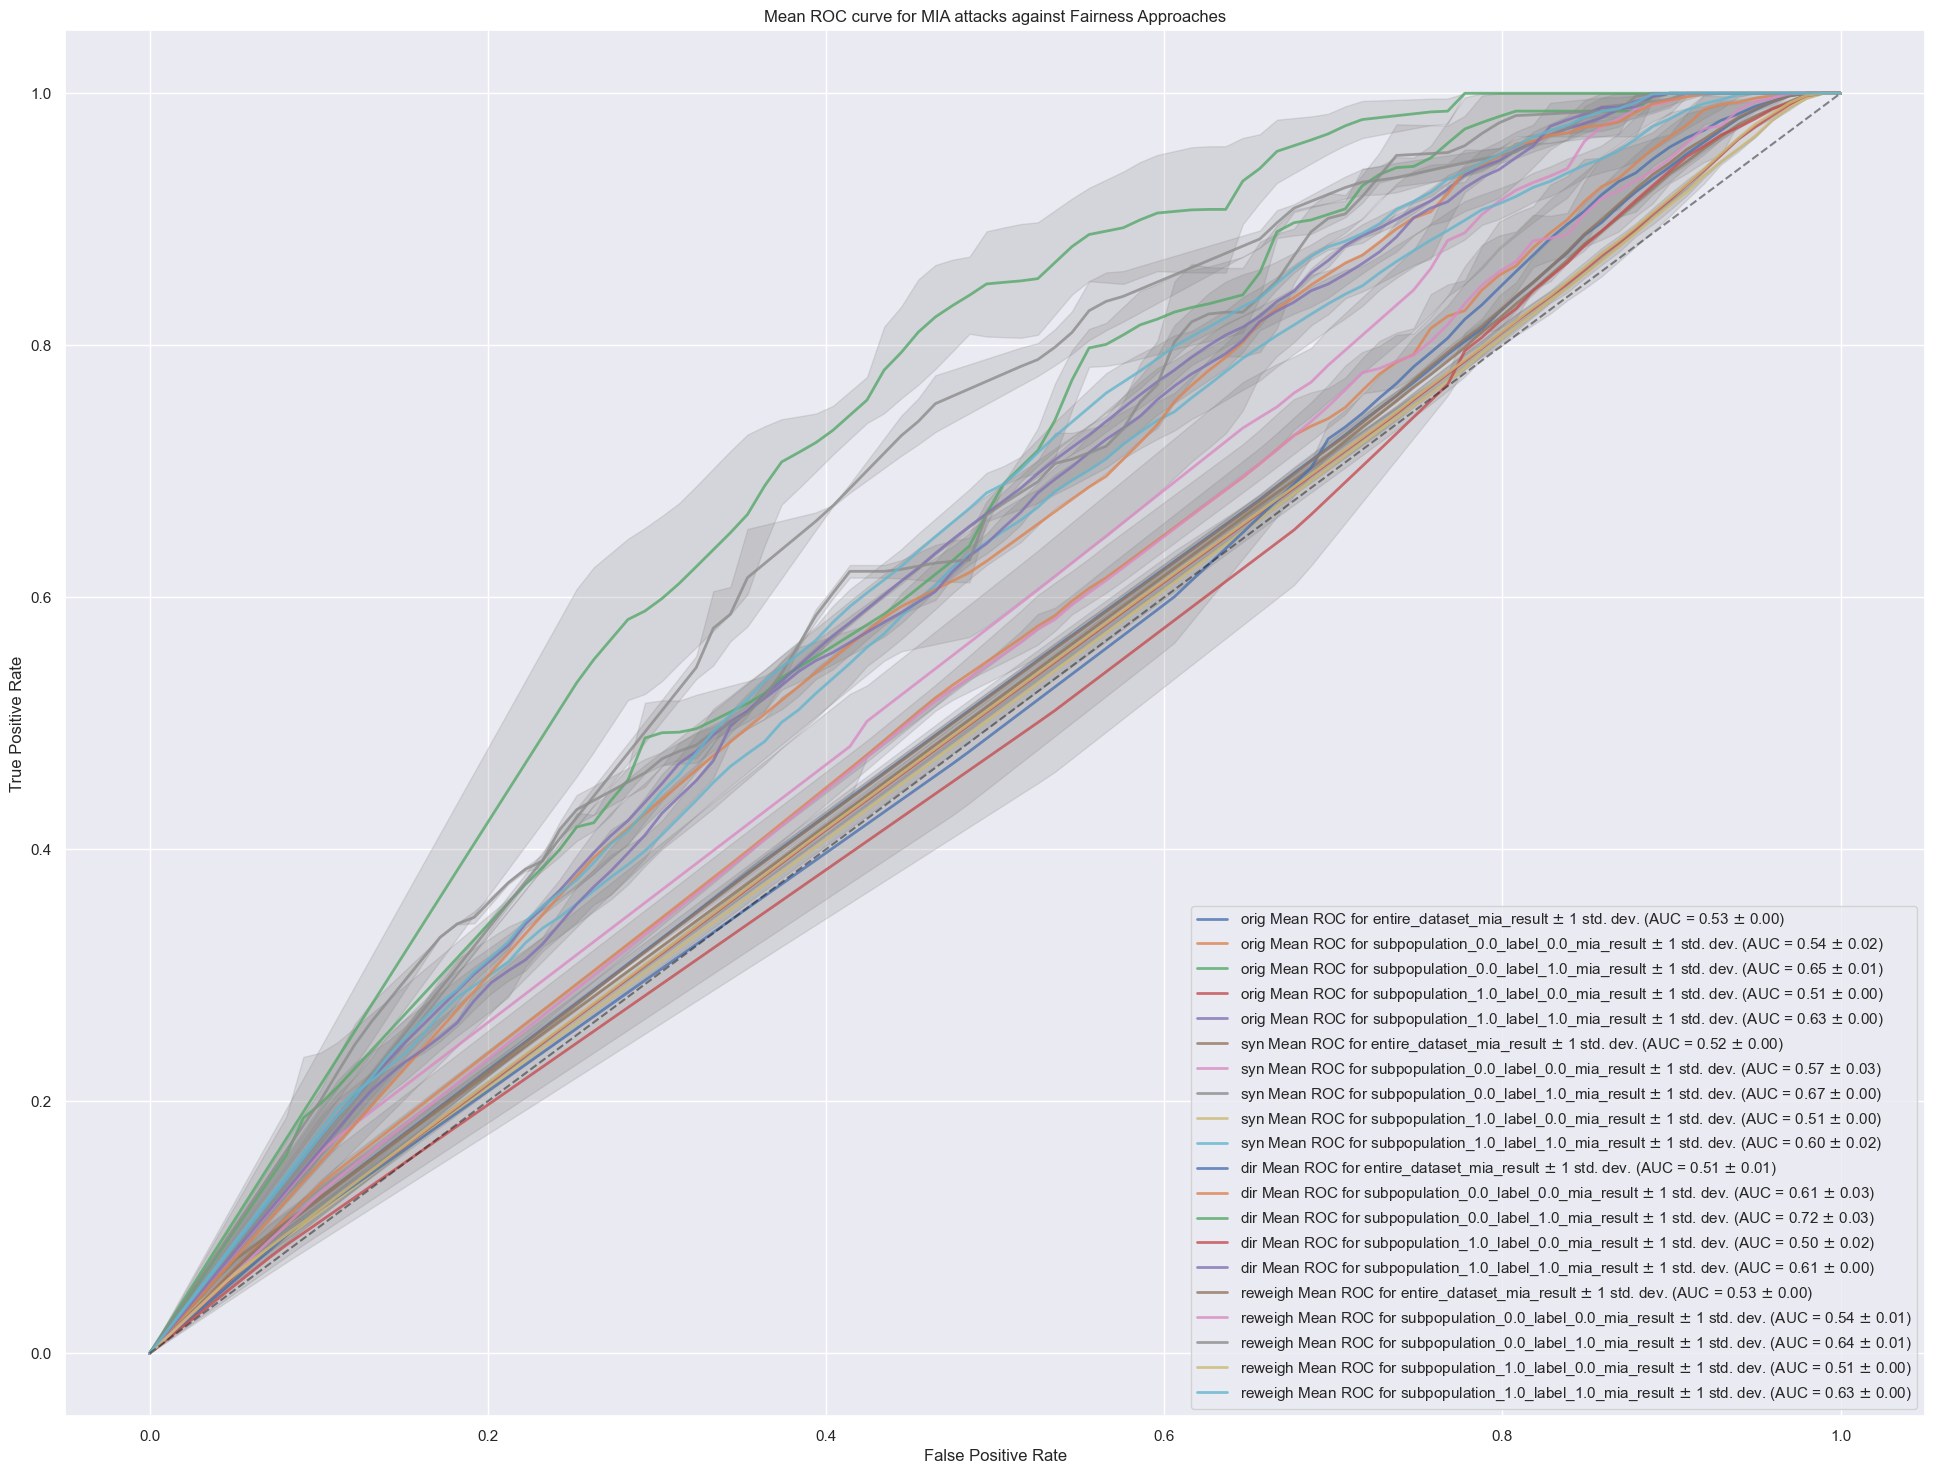

In [42]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics, dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

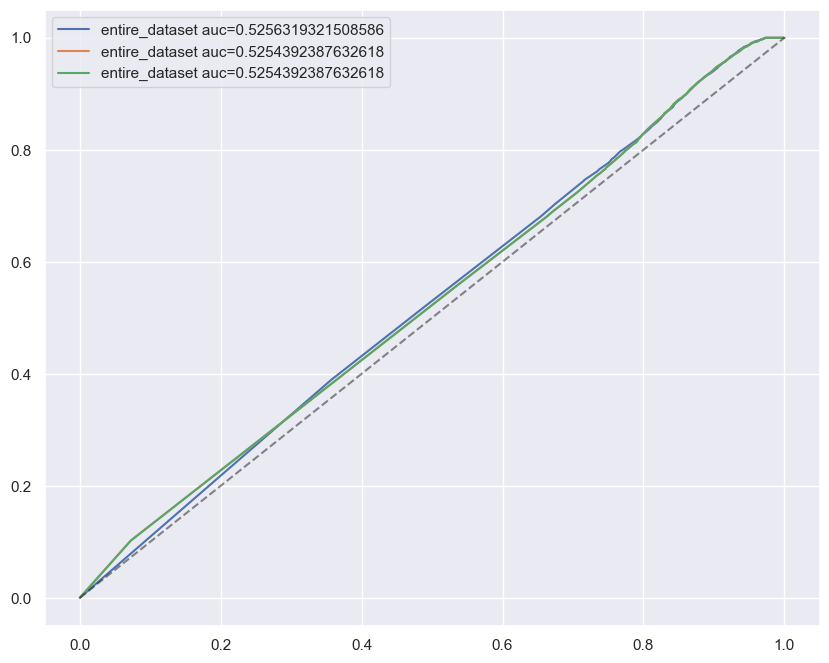

In [43]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [44]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("mia_auc")}

In [45]:
orig_mia_metrics_mean

{'entire_dataset_mia_auc': 0.5255034698924608,
 'entire_dataset_label_0.0_mia_auc': 0.5137987191462026,
 'entire_dataset_label_1.0_mia_auc': 0.6274308878864304,
 'subpopulation_0.0_label_0.0_mia_auc': 0.5446910915334813,
 'subpopulation_0.0_label_1.0_mia_auc': 0.6463019250253293,
 'subpopulation_1.0_label_0.0_mia_auc': 0.512991818629668,
 'subpopulation_1.0_label_1.0_mia_auc': 0.6264666665180112}

In [46]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        egr_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,entire_dataset_label_0.0_mia_auc,entire_dataset_label_1.0_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,,,
orig,0.525503,0.513799,0.627431,0.544691,0.646302,0.512992,0.626467
syn,0.521038,0.510229,0.608881,0.572462,0.669571,0.508549,0.604757
dir,0.514774,0.500797,0.620064,0.612552,0.720095,0.497379,0.614488
rew,0.525335,0.514664,0.632990,0.541662,0.643938,0.513965,0.632240
egr,0.524416,0.514986,0.602387,0.548201,0.626309,0.514143,0.601248


<Axes: xlabel='Classifier MIA Attacks'>

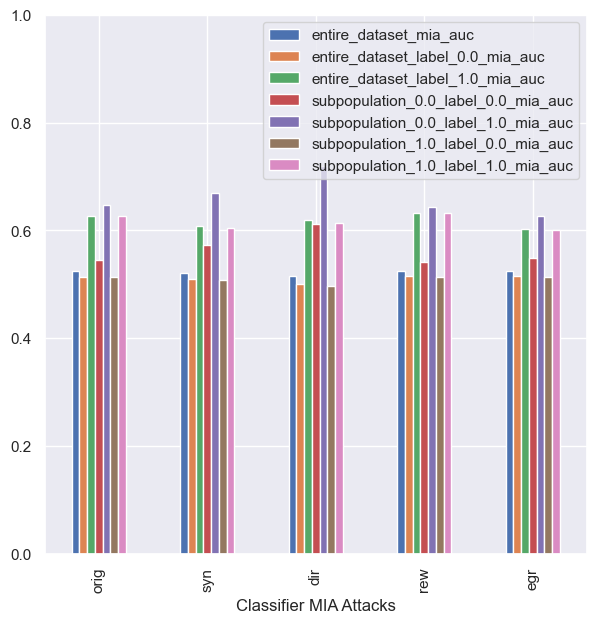

In [47]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [48]:
# Creating data structures to plot point categorical plot from seaborn

In [49]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [50]:
orig_mia_metrics_att_ad

{'entire_dataset_mia_attacker_advantage': [0.04329572290737338,
  0.044148517449488334,
  0.044148517449488334],
 'entire_dataset_label_0.0_mia_attacker_advantage': [0.026098858435519068,
  0.025821590364842772,
  0.025821590364842772],
 'entire_dataset_label_1.0_mia_attacker_advantage': [0.17379471583696354,
  0.1864243139302857,
  0.1864243139302857],
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': [0.05320537219292043,
  0.09221701102801372,
  0.09221701102801372],
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': [0.2242147922998986,
  0.25612968591691987,
  0.25612968591691987],
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': [0.02554794482548528,
  0.02425695461893418,
  0.02425695461893418],
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': [0.17329450438139654,
  0.18420743743375112,
  0.18420743743375112]}

In [51]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.04329572290737338],
 ['orig', 'entire_dataset', 0.044148517449488334],
 ['orig', 'entire_dataset', 0.044148517449488334],
 ['orig', 'entire_dataset_label_0.0', 0.026098858435519068],
 ['orig', 'entire_dataset_label_0.0', 0.025821590364842772],
 ['orig', 'entire_dataset_label_0.0', 0.025821590364842772],
 ['orig', 'entire_dataset_label_1.0', 0.17379471583696354],
 ['orig', 'entire_dataset_label_1.0', 0.1864243139302857],
 ['orig', 'entire_dataset_label_1.0', 0.1864243139302857],
 ['orig', 'subpopulation_0.0_label_0.0', 0.05320537219292043],
 ['orig', 'subpopulation_0.0_label_0.0', 0.09221701102801372],
 ['orig', 'subpopulation_0.0_label_0.0', 0.09221701102801372],
 ['orig', 'subpopulation_0.0_label_1.0', 0.2242147922998986],
 ['orig', 'subpopulation_0.0_label_1.0', 0.25612968591691987],
 ['orig', 'subpopulation_0.0_label_1.0', 0.25612968591691987],
 ['orig', 'subpopulation_1.0_label_0.0', 0.02554794482548528],
 ['orig', 'subpopulation_1.0_label_0.0', 0.0242

In [52]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.043296
1,orig,entire_dataset,0.044149
2,orig,entire_dataset,0.044149
3,orig,entire_dataset_label_0.0,0.026099
4,orig,entire_dataset_label_0.0,0.025822
...,...,...,...
100,egr,subpopulation_1.0_label_0.0,0.028038
101,egr,subpopulation_1.0_label_0.0,0.028038
102,egr,subpopulation_1.0_label_1.0,0.180895
103,egr,subpopulation_1.0_label_1.0,0.188459


KeyError: 'egr'

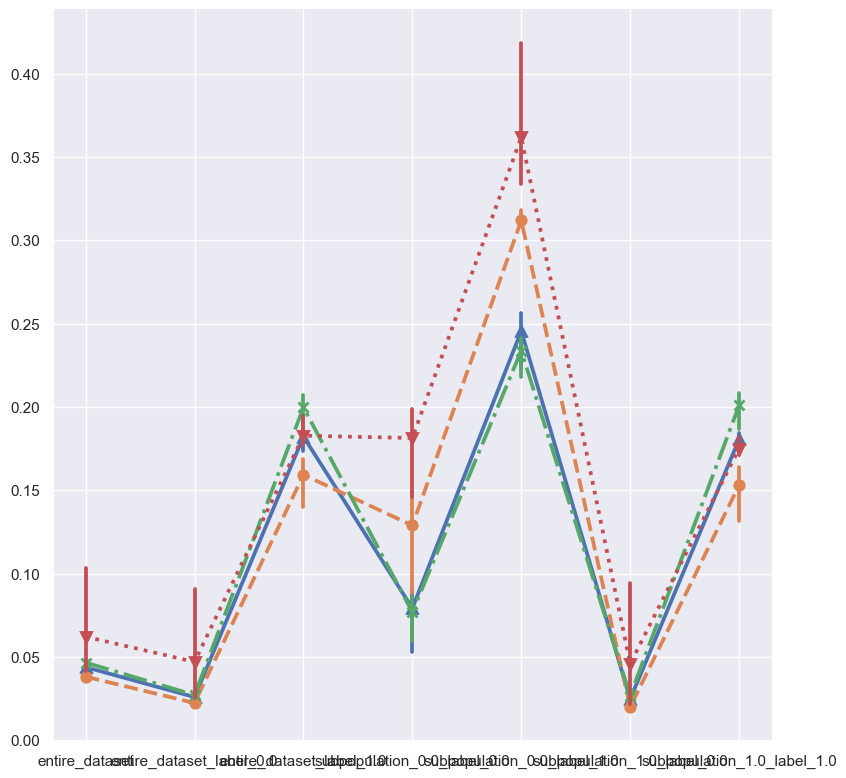

In [53]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v"], linestyles=["-", "--", "-.", ":"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


In [ ]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v"], linestyles=["-", "--", "-.", ":"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [ ]:
pd.DataFrame(orig_mia_metrics_att_ad)

In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [ ]:
orig_mia_metrics_mean

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("mia_ppv")}

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

In [ ]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v"], linestyles=["-", "--", "-.", ":"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [ ]:
import pandas as pd

In [ ]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

In [ ]:
df[["age", "labels"]].value_counts(normalize=True)

In [ ]:
df.drop_duplicates()